In [1]:
import torch
import torch.nn as nn
from networks import SCLIPNN
import clip
from PIL import Image
from sentence_transformers import SentenceTransformer
import torchvision.transforms.functional as fn

In [9]:
device = "cuda" if torch.cuda.is_available() else "cpu"
spanish_sentences = ["un perro blanco en el cesped verde", "una fruta amarilla apetitosa", "un avion volando sobre las nubes", "la muchacha de pelo rojo"]
english_sentences = ["a white dog on the green grass", "a tasty yellow fruit", "a plane flying over the clouds", "the red hair girl"]
sbert_model = SentenceTransformer('distiluse-base-multilingual-cased-v1')

In [10]:
clip_model, preprocess = clip.load("ViT-B/32", device=device)
sp_text = clip.tokenize(spanish_sentences).to(device)
en_text = clip.tokenize(english_sentences).to(device)

In [11]:
def reshape(im):
    print("This is size of original image:",im.size, "\n")
    width, height = im.size
    # print("W: {} and H: {}".format(width, height))
    if width > 1000 or height > 1000:
        scale = 3
    elif width > 500 or height > 500:
        scale = 2
    else:
        scale = 1    
    new_width = int(width / scale)
    new_height = int(height / scale)
    #image = preprocess(im)
    image = fn.resize(im, size=[new_width])
    print("This is size of resized image:",image.size, "\n")
    return image

This is size of original image: (1300, 1300) 

This is size of resized image: (433, 433) 



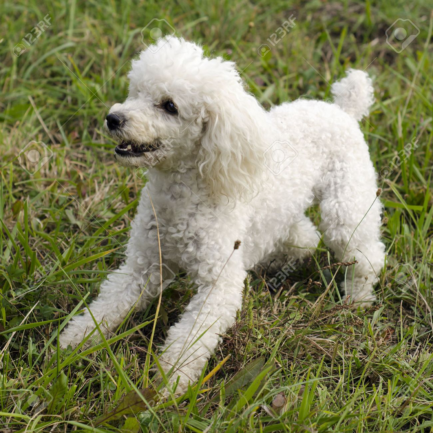

This is size of original image: (1200, 675) 

This is size of resized image: (711, 400) 



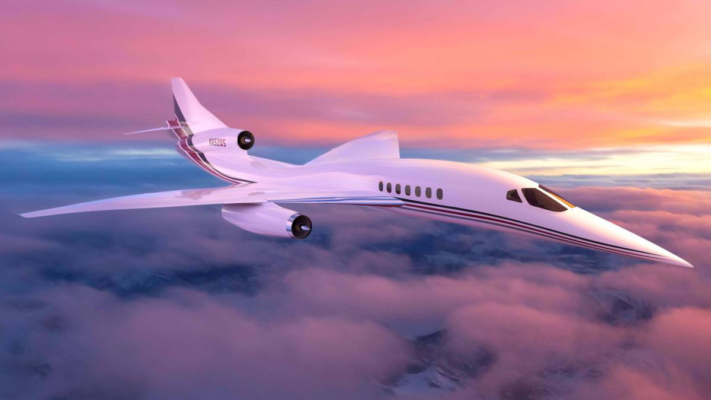

This is size of original image: (564, 753) 

This is size of resized image: (282, 376) 



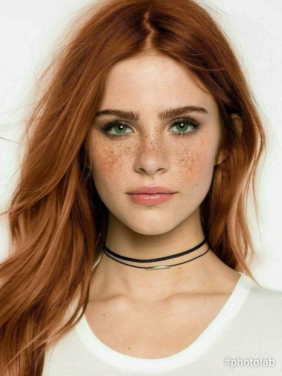

In [12]:
im_poodle = Image.open("imgs/poodle.jpg")
im_plane = Image.open("imgs/plane.jpg")
im_redgirl = Image.open("imgs/redgirl.jpg")
images = {"poodle": im_poodle, "plane":im_plane, "redgirl":im_redgirl}
for i, (name, im) in enumerate(images.items()):
    images[name] = reshape(im) #.unsqueeze(0).to(device)
    images[name].show()

In [13]:
import numpy as np
def get_logits(image_features, text_features):
    # normalized features
    if text_features.dtype == torch.int64:
        text_features = text_features.type(torch.FloatTensor)
    image_features = (image_features / image_features.norm(dim=-1, keepdim=True)).to(device)
    text_features = (text_features / text_features.norm(dim=-1, keepdim=True)).to(device)

    # cosine similarity as logits
    logit_scale = nn.Parameter(torch.ones([]) * np.log(1 / 0.07))
    logit_scale = logit_scale.exp().to(device)
    logits_per_image = logit_scale * image_features @ text_features.t()
    logits_per_text = logits_per_image.t()

    # shape = [global_batch_size, global_batch_size]
    return logits_per_image, logits_per_text    

In [14]:
def sbert_to_clip(sbert_features):
    input_size = sbert_features.shape[1]
    PATH = "models/best_model.pt"
    model = SCLIPNN(input_size,850)
    model.load_state_dict(torch.load(PATH))
    model.eval()
    output = model(sbert_features)
    return output

In [15]:
with torch.no_grad():
    print("Sentence in Spanish: {}".format(spanish_sentences))
    print("Sentence in English: {}".format(english_sentences))
    sp_sbert_features = torch.from_numpy(sbert_model.encode(spanish_sentences))
    sp_sbert_features = sbert_to_clip(sp_sbert_features).type(torch.float16)
    en_sbert_features = torch.from_numpy(sbert_model.encode(english_sentences))
    en_sbert_features = sbert_to_clip(en_sbert_features).type(torch.float16)
    sp_clip_features = clip_model.encode_text(sp_text)
    en_clip_features = clip_model.encode_text(en_text)
    for name, im in images.items():
        image = preprocess(im).unsqueeze(0).to(device)
        image_features = clip_model.encode_image(image)
        sp_logits_image_clip, sp_logits_text_clip = get_logits(image_features, sp_clip_features)
        sp_logits_image_sbert, sp_logits_text_sbert = get_logits(image_features, sp_sbert_features)
        sp_probs_clip = sp_logits_image_clip.softmax(dim=-1).cpu().numpy()
        sp_probs_sbert = sp_logits_image_sbert.softmax(dim=-1).cpu().numpy()
        en_logits_image_clip, en_logits_text_clip = get_logits(image_features, en_clip_features)
        en_logits_image_sbert, en_logits_text_sbert = get_logits(image_features, en_sbert_features)
        en_probs_clip = en_logits_image_clip.softmax(dim=-1).cpu().numpy()
        en_probs_sbert = en_logits_image_sbert.softmax(dim=-1).cpu().numpy()
        print('-'*30, ' Image: {} '.format(name),'-'*30)
        print("Spanish CLIP probs:", sp_probs_clip[0]) 
        print("Spanish SBERT probs:", sp_probs_sbert[0]) 
        print("English CLIP probs:", en_probs_clip[0]) 
        print("English SBERT probs:", en_probs_sbert[0]) 

Sentence in Spanish: ['un perro blanco en el cesped verde', 'una fruta amarilla apetitosa', 'un avion volando sobre las nubes', 'la muchacha de pelo rojo']
Sentence in English: ['a white dog on the green grass', 'a tasty yellow fruit', 'a plane flying over the clouds', 'the red hair girl']
------------------------------  Image: poodle  ------------------------------
Spanish CLIP probs: [0.516  0.153  0.1095 0.2212]
Spanish SBERT probs: [0.684   0.07904 0.0667  0.17   ]
English CLIP probs: [0.7114  0.128   0.05942 0.1011 ]
English SBERT probs: [0.699   0.07355 0.0692  0.1581 ]
------------------------------  Image: plane  ------------------------------
Spanish CLIP probs: [0.2286  0.1194  0.5337  0.11847]
Spanish SBERT probs: [0.0997  0.11633 0.6274  0.1565 ]
English CLIP probs: [0.1896 0.1382 0.5264 0.1456]
English SBERT probs: [0.12415 0.10516 0.611   0.1597 ]
------------------------------  Image: redgirl  ------------------------------
Spanish CLIP probs: [0.1837 0.2065 0.1276 0.482